<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Авторы материала: Павел Нестеров. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашняя работа №4
## <center> Логистическая регрессия в задаче тегирования вопросов StackOverflow

**Надо вывести формулы, где это просится (да, ручка и бумажка), заполнить код в клетках и выбрать ответы в [веб-форме](https://docs.google.com/forms/d/1I_ticU8rpeoGJjsBUcaInpvgdxdq60hV7IcSvo4rlGo/).**

## 0. Описание задачи

В этой домашней работе мы с вами изучим и запрограммируем модель для прогнозирования тегов по тексту вопроса на базе многоклассовой логистической регрессии. В отличие от обычной постановки задачи классификации (multiclass), в данном случае один пример может принадлежать одновременно к нескольким классам (multilabel). Мы будем реализовывать онлайн версию алгоритма мультиклассовой классификации.

Мы будем использовать небольшую выборку из протеггированных вопросов с сайта StackOverflow размером в 125 тысяч примеров (около 150 Мб, скачайте по [этой](https://drive.google.com/open?id=0B4bl7YMqDnViYVo0V2FubFVhMFE) ссылке).

PS: Можно показать, что такая реализация совсем не эффективная и проще было бы использовать векторизированные вычисления. Для данного датасета так и есть. Но на самом деле подобные реализации используются в жизни, но естественно, написаны они не на Python. Например, в онлайн моделях прогнозирования [CTR](https://en.wikipedia.org/wiki/Click-through_rate) юзеру показывается баннер, затем в зависимости от наличия клика происходит обновление параметров модели. В реальной жизни параметров модели может быть несколько сотен миллионов, а у юзера из этих ста миллионов от силы сто или тысяча параметров отличны от нуля, векторизировать такие вычисления не очень эффективно. Обычно все это хранится в огромных кластерах в in-memory базах данных, а обработка пользователей происходит распределенно.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm_notebook
import pandas as pd
from collections import defaultdict

# поменяйте на свой путь
DS_FILE_NAME = '../../data/stackoverflow_sample_125k.tsv'
TAGS_FILE_NAME = '../../data/top10_tags.tsv'

In [2]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = set(top_tags)
print(top_tags)

{'c++', 'python', 'javascript', 'c#', 'ios', 'html', 'jquery', 'php', 'android', 'java'}


## 1. Многоклассовая логистическая регрессия

Вспомним, как получается логистическая регрессия для двух классов $\left\{0, 1\right\}$, вероятность принадлежности объекта к классу $1$ выписывается по теореме Байеса:

$$\large \begin{array}{rcl}
p\left(c = 1 \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right) + p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} \\
&=& \dfrac{1}{1 + e^{-a}} \\
&=& \sigma\left(a\right)
\end{array}$$
где:
- $\vec{x}$ – вектор признаков объекта
- $\sigma$ – обозначение функции логистического сигмоида при скалярном аргументе
- $a = \log \frac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} = \sum_{i=0}^M w_i x^i$ – это отношение мы моделируем линейной функцией от признаков объекта и параметров модели

Данное выражение легко обобщить до множества из $K$ классов, изменится только знаменатель в формуле Байеса. Запишем вероятность принадлежности объекта к классу $k$:
$$\large \begin{array}{rcl}
p\left(c = k \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = k\right)p\left(c = k\right)}{\sum_{i=1}^K p\left(\vec{x} \mid c = i\right)p\left(c = i\right)} \\
&=& \dfrac{e^{z_k}}{\sum_{i=1}^{K}e^{z_i}} \\
&=& \sigma_k\left(\vec{z}\right)
\end{array}$$
где:
- $\sigma_k$ – обозначение функции softmax при векторном аргументе
- $z_k = \log p\left(\vec{x} \mid c = k\right)p\left(c = k\right) = \sum_{i=0}^M w_{ki} x^i$ – это выражение моделируется линейной функций от признаков объекта и параметров класса $k$

Для моделирования полного правдоподобия примера мы используем [категориальное распределение](https://en.wikipedia.org/wiki/Categorical_distribution), а лучше его логарифм (для удобства):

$$\large \begin{array}{rcl}
\mathcal{L} = \log p\left({\vec{x}}\right) &=& \log \prod_{i=1}^K \sigma_i\left(\vec{z}\right)^{y_i} \\
&=& \sum_{i=1}^K y_i \log \sigma_i\left(\vec{z}\right)
\end{array}$$

Получается хорошо знакомая нам функция [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) (если домножить на $-1$). Правдоподобие нужно максимизировать, а, соответственно, перекрестную энтропию нужно минимизировать. Продифференцировав по параметрам модели, мы _легко_ получим правила обновления весов для градиентного спуска, **проделайте этот вывод, если вы его не делали** (если вы вдруг сдались, то на [этом](https://www.youtube.com/watch?v=-WiR16raQf4) видео есть разбор вывода, понимание этого вам понадобится для дальнейшего выполнения задания):

$$\large \begin{array}{rcl}
\frac{\partial \mathcal{L}}{\partial w_{km}} &=& x_m \left(y_k - \sigma_k\left(\vec{z}\right)\right)
\end{array}$$

В стандартной формулировке получается, что вектор $\left(\sigma_1, \sigma_2, \ldots, \sigma_K\right)$ образует дискретное вероятностное распределение, т.е. $\sum_{i=1}^K \sigma_i = 1$. Но в нашей постановке задачи каждый пример может иметь несколько тегов или одновременно принадлежать к нескольким классам. Для этого мы немного изменим модель:
- будем считать, что все теги независимы друг от друга, т.е. каждый исход – это логистическая регрессия на два класса (либо есть тег, либо его нет), тогда вероятность наличия тега у примера запишется следующим образом (каждый тег/класс как и в многоклассовой логрегрессии имеет свой набор параметров):
$$\large p\left(\text{tag}_k \mid \vec{x}\right) = \sigma\left(z_k\right) = \sigma\left(\sum_{i=1}^M w_{ki} x^i \right)$$
- наличие каждого тега мы будем моделировать с помощью <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">распределения Бернулли</a>

Ваше первое задание –  записать упрощенное выражение логарифма правдоподобия примера с признаками $\vec{x}$. Как правило, многие алгоритмы оптимизации имеют интерфейс для минимизации функции, мы последуем этой же традиции, и домножим полученное выражение на $-1$, а во второй части выведем формулы для минимизации полученного выражения.

<font color="red">Варианты ответа:</font>
1. $\large -\mathcal{L} = -\sum_{i=1}^M y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
2. $\large -\mathcal{L} = -\sum_{i=1}^K y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
3. $\large -\mathcal{L} = -\sum_{i=1}^K z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$
4. $\large -\mathcal{L} = -\sum_{i=1}^M z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$

2

## 2. Вывод формулы обновления весов

В качестве второго задания вам предоставляется возможность вывести формулу градиента для $-\mathcal{L}$.

<font color="red">Варианты ответа:</font>:
1. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(\sigma\left(z_k\right) - y_k\right)$
2. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(y_k - \sigma\left(z_k\right)\right)$
3. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(\sigma\left(z_k\right)x_m - y_k\right)$
4. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(y_k - \sigma\left(z_k\right)x_m\right)$

In [ ]:
2

## 3. Имплементация базовой модели

Вам предлагается каркас класса модели, разберите его внимательно, обращайте внимание на комментарии. Затем заполните пропуски, запустите полученную модель и ответьте на проверочный вопрос.

Как вы могли уже заметить, при обновлении веса $w_{km}$ используется значение признака $x_m$, который равен $0$ если слова с индексом $m$ нет в предложении, и больше нуля, если такое слово есть. Соответственно, при вычислении линейной комбинации $z$ весов модели и признаков примера необходимо учитывать только ненулевые признаки объекта.

Подсказка:
- если реализовывать вычисление сигмоида так же, как в формуле, то при большом отрицательном значении $z$ вычисление $e^{-z}$ превратится в очень большое число, которое вылетит за допустимые пределы
- в то же время $e^{-z}$ от большого положительного $z$ будет нулем
- воспользуйтесь свойствами функции $\sigma$ для того, чтобы пофиксить эту ошибку

In [3]:
import time

In [3]:
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
#                     print(tag, y, sentence)
#                     time.sleep(5)
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # z += ...
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sigma = ...
#                     if z < -10:
#                         sigma = 0
#                     elif z > 10:
#                         sigma = 1
#                     else:
#                     sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    sigma = 1.0/(1.0 + np.exp((-1.0)*z))
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sample_loss += ...
#                     if y:
#                         if sigma < tolerance:
#                             sample_loss += (-1.0)*np.log(tolerance)
#                         else:
#                             sample_loss += (-1.0)*np.log(sigma)
#                     else:
#                         if 1 - sigma < tolerance:
#                             sample_loss += (-1.0)*np.log(tolerance)
#                         else:
#                             sample_loss += (-1.0)*np.log(1 - sigma)
                    if sigma < tolerance:
                        sample_loss += (-1.0)*(y*np.log(tolerance) + (1 - y)*np.log(1 - sigma))
                    elif (1 - sigma) < tolerance:
                        sample_loss += (-1.0)*(y*np.log(sigma) + (1 - y)*np.log(tolerance))
                    else:
                        sample_loss += (-1.0)*(y*np.log(sigma) + (1 - y)*np.log(1 - sigma))
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        # dLdw = ...
                        dLdw = y - sigma
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                        
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    
                n += 1
                if n%1000 == 0:
                    print(sample_loss)        
                self._loss.append(sample_loss)

In [4]:
# создадим эксемпляр модели и пройдемся по датасету
model = LogRegressor()
model.iterate_file()

/opt/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: overflow encountered in exp


61.30784781
23.9656377871
0.0
36.8631974053
1.11022302463e-16
0.0
22.7248361085
2.41948233597e-07
0.0078541935592
1.39267486442e-10
0.580115777832
1.2237814889e-06
0.0339833824533
91.8987745321
36.5310075119
0.0
0.0
30.6334967405
36.8413614879
6.46939267842e-05
0.0
0.0380508690246
73.6827229758
3.40093369302
1.22124532709e-15
2.22044604925e-16
5.74602587749e-11
4.91162666094e-13
9.45851343021
42.389729262
36.8413614879
0.0976063898327
0.0
36.8413614879
0.0
4.87637982554
73.6827229758
13.2696198416
36.8735011453
0.0
0.0
0.0
75.1010269765
36.8413620376
36.8413614879
4.71274498601
4.4408920985e-16
0.0
7.41851025057e-12
3.00756588267
0.0
6.62649249628
73.6827229758
24.9432972446
0.000588946790504
6.22935521901e-07
0.0
115.061178197
24.5510734988
0.0
36.8413615783
1.43266776652e-07
36.8413614881
0.0
13.3348992641
34.4674103226
36.8413614879
5.16088144302
73.6827229758
49.1285675355
1.11022302463e-16
0.790797117998
61.5209026945
36.8413614879
8.99476271648e-10
3.64241097258e-05
36.8413614879

In [9]:
np.log(1e-16)

-36.841361487904734

Проверим, действительно ли значение отрицательного логарифмического правдоподобия уменьшалось. Так как мы используем стохастический градентный спуск, не стоит ожидать плавного падения функции ошибки. Мы воспользуемся скользящим средним с окном в 10 000 примеров, чтобы хоть как то сгладить график.

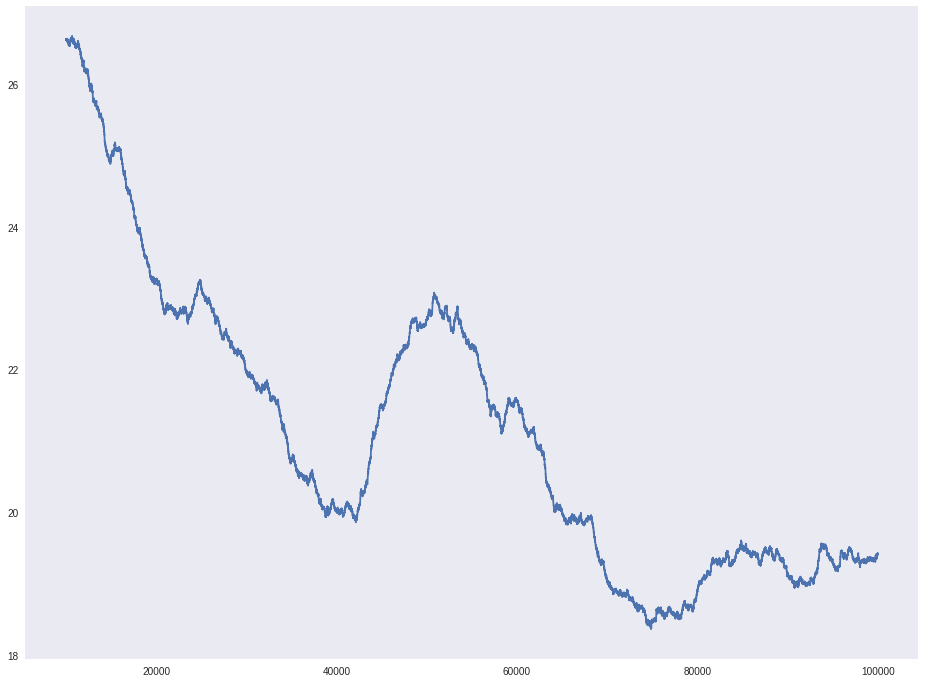

In [5]:
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [6]:
print('Mean of the loss function on the last 10k train samples: %0.2f' % np.mean(model._loss[-35000:-25000]))

Mean of the loss function on the last 10k train samples: 19.42


Вычислите среднее значение функции стоимости на последних 10 000 примеров тренировочного набора, к какому из значений ваш ответ ближе всего?

<font color="red">Варианты ответа:</font>:
1. 17.54
2. 18.64
3. 19.74
4. 20.84

## 4. Тестирование модели

В базовой модели первые 100 000 строк используются для обучения, а оставшиеся – для тестирования. Как вы можете заметить, значение отрицательного логарифмического правдоподобия не очень информативно, хоть и позволяет сравнивать разные модели. В качестве четвертого задания вам необходимо модифицировать базовую модель таким образом, чтобы метод `iterate_file` возвращал значение _точности_ на тестовой части набора данных. 

Точность определим следующим образом:
- считаем, что тег у вопроса присутствует, если спрогнозированная вероятность тега больше 0.9
- точность одного примера расчитывается как [коэффициент Жаккара](https://ru.wikipedia.org/wiki/Коэффициент_Жаккара) между множеством настоящих тегов и предсказанных моделью
  - например, если у примера настоящие теги ['html', 'jquery'], а по версии модели ['ios', 'html', 'java'], то коэффициент Жаккара будет равен |['html', 'jquery'] $\cap$ ['ios', 'html', 'java']| / |['html', 'jquery'] $\cup$ ['ios', 'html', 'java']| = |['html']| / |['jquery', 'ios', 'html', 'java']| = 1/4
- метод `iterate_file` возвращает **среднюю** точность на тестовом наборе данных

In [ ]:
class LogRegressor1():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        acc = 0
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0
                pred_tags = set()
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
#                     print(tag, y, sentence)
#                     time.sleep(5)
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # z += ...
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sigma = ...
#                     if z < -10:
#                         sigma = 0
#                     elif z > 10:
#                         sigma = 1
#                     else:
#                     sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sample_loss += ...
#                     if y:
#                         if sigma < tolerance:
#                             sample_loss += (-1.0)*np.log(tolerance)
#                         else:
#                             sample_loss += (-1.0)*np.log(sigma)
#                     else:
#                         if 1 - sigma < tolerance:
#                             sample_loss += (-1.0)*np.log(tolerance)
#                         else:
#                             sample_loss += (-1.0)*np.log(1 - sigma)
                    if sigma < tolerance:
                        sample_loss += (-1.0)*(y*np.log(tolerance) + (1 - y)*np.log(sigma))
                    elif (1 - sigma) < tolerance:
                        sample_loss += (-1.0)*(y*np.log(sigma) + (1 - y)*np.log(tolerance))
                    else:
                        sample_loss += (-1.0)*(y*np.log(sigma) + (1 - y)*np.log(1 - sigma))
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        # dLdw = ...
                        dLdw = y - sigma
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                        
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    if n >= top_n_train:
                        if sigma > 0.9:
                            pred_tags.add(tag)
                    
                n += 1
                if (n >= top_n_train):
                    # вычисляем коэфф жаккара
                    jac = len(pred_tags & tags)/len(pred_tags | tags)
                    acc += jac
                
                
                if n%1000 == 0:
                    print(sample_loss)
                    if (n >= top_n_train):
                        print(pred_tags, tags, jac, acc)
                self._loss.append(sample_loss)
            
        return acc/(total-top_n_train)

In [ ]:
model = LogRegressor1()
acc = model.iterate_file()
# выведем полученное значение с точностью до двух знаков
print('%0.2f' % acc)

Ответьте на вопрос,  к какому значению ближе всего полученное значение точности?
<font color="red">Варианты ответа:</font>:
1. 0.39
2. 0.49
3. 0.59
4. 0.69

## 5. $L_2$-регуляризация

В качестве пятого задания вам необходимо добавить в класс `LogRegressor` поддержку $L_2$-регуляризации. В методе `iterate_file` должен появиться параметр `lmbda=0.01` со значением по умолчанию. С учетом регуляризации новая функция стоимости примет вид:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \frac{\lambda}{2} \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2
\end{array}$$

Градиент первого члена суммы мы уже вывели, а для второго он имеет вид:

$$\large \begin{array}{rcl}
\frac{\partial}{\partial w_{ki}} \frac{\lambda}{2} R\left(W\right) &=& \lambda w_{ki}
\end{array}$$

Если мы на каждом примере будем делать честное обновление всех весов, то все очень замедлится, ведь нам придется на каждой итерации пробегать по всем словам словаря. В ущерб теоретической точности вы используем грязный трюк: мы будем регуляризаровать только те слова, которые присутствуют в текущем предложении. Не забывайте, что смещение не регуляризируется. `sample_loss` тоже должен остаться без изменений.

In [16]:
class LogRegressor2():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     lmbda = 0.01, #L2-regularization
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        acc = 0
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0
                pred_tags = set()
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
#                     print(tag, y, sentence)
#                     time.sleep(5)
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # z += ...
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sigma = ...
#                     if z < -10:
#                         sigma = 0
#                     elif z > 10:
#                         sigma = 1
#                     else:
#                     sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sample_loss += ...
                    if y:
                        if sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(sigma)
                    else:
                        if 1 - sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(1 - sigma)
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        # dLdw = ...
                        dLdw = y - sigma
                        self._b[tag] -= -learning_rate*dLdw
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:  
                            dLdw = y - sigma - lmbda*self._w[tag][self._vocab[word]]
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        
                    if n >= top_n_train:
                        if sigma > 0.9:
                            pred_tags.add(tag)
                    
                n += 1
                if (n >= top_n_train):
                    # вычисляем коэфф жаккара
                    jac = len(pred_tags & tags)/len(pred_tags | tags)
                    acc += jac
                
                
                if n%1000 == 0:
                    print(sample_loss)
                    if (n >= top_n_train):
                        print(pred_tags, tags, jac, acc)
                self._loss.append(sample_loss)
            
        return acc/(total-top_n_train)

/opt/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: overflow encountered in exp


49.3376327676
53.1590817392
0.0
6.77304615853e-05
6.66133814775e-16
3.04599914379e-06
0.00500317846736
28.1298857029
2.24220045698
0.0
19.4281916718
5.96392380022e-10
4.87568375879
66.6804246176
4.98180562407e-08
14.277266021
7.11673634466e-07
0.285925761631
36.8413614879
4.4297767684
73.6827229758
31.1828555082
73.6827229758
0.360340275317
1.73080438885e-10
9.60347863577
2.8431355411e-07
0.0534557327476
1.16684439888e-13
0.000688935100601
36.8413614879
0.000402529680278
0.0
0.000547643213922
8.14903700075e-14
0.000715111323244
21.7912286056
26.0413237152
11.8126562276
2.49689158238e-13
2.05762132305
0.0
40.5370409714
38.7108180937
13.6004230878
2.70236190154
11.8301295288
0.00510921476075
0.0633470965033
22.9735952107
0.0
0.0108069334916
0.623984571137
20.8074128486
0.323149237723
0.326399608591
2.84594703754e-09
127.266312081
0.0409269179339
0.00083956173725
70.939104728
39.0062145679
67.4299439373
0.000119527246725
8.03935932182
2.92177425301e-07
2.22044604925e-16
0.000304998213452


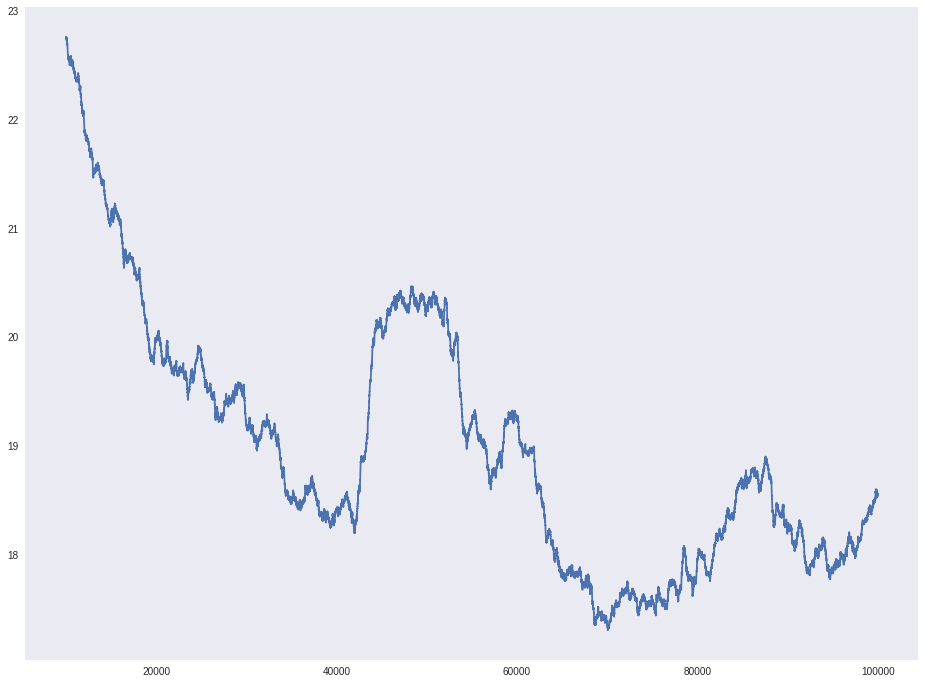

In [17]:
model = LogRegressor2()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

Ответьте на вопрос, к какому значению ближе всего полученное значение точности?
<font color="red">Варианты ответа:</font>:
1. 0.3
2. 0.35
3. 0.4
4. 0.52

## 6. ElasticNet регуляризация, вывод
Помимо $L_2$ регуляризации, часто используется $L_1$ регуляризация.

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \lambda \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right|
\end{array}$$

Если линейно объединить $L_1$ и $L_2$ регуляризацию, то полученный тип регуляризации называется ElasticNet:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \lambda R\left(W\right) \\
&=& -\mathcal{L} + \lambda \left(\gamma \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2 + \left(1 - \gamma\right) \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right| \right)
\end{array}$$
- где $\gamma \in \left[0, 1\right]$

В качестве шестого вопроса вам предлагается вывести формулу градиента ElasticNet регуляризации (не учитывая $-\mathcal{L}$). 

<font color="red">Варианты ответа:</font>:
1. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) w_{ki}\right)$ 
2. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma \left|w_{ki}\right| + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
3. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
4. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(\gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$

## 7. ElasticNet регуляризация, имплементация

В качестве седьмой задачи, вам предлается изменить класс `LogRegressor` таким образом, чтобы метод `iterate_file` принимал два параметра со значениями по умолчанию `lmbda=0.0002` и `gamma=0.1`. Сделайте один проход по датасету с включенной ElasticNet регуляризацией и заданными значениями по умолчанию и ответьте на вопрос.

In [20]:
class LogRegressor3():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     lmbda = 0.0002, #L2-regularization
                     gamma = 0.1, #L1-regularization
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        acc = 0
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0
                pred_tags = set()
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
#                     print(tag, y, sentence)
#                     time.sleep(5)
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # z += ...
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sigma = ...
#                     if z < -10:
#                         sigma = 0
#                     elif z > 10:
#                         sigma = 1
#                     else:
#                         sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sample_loss += ...
                    if y:
                        if sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(sigma)
                    else:
                        if 1 - sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(1 - sigma)
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        # dLdw = ...
                        dLdw = y - sigma
                        self._b[tag] -= -learning_rate*dLdw
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:
                            w_ij = self._w[tag][self._vocab[word]]
                            dLdw = y - sigma - lmbda*(2*gamma*w_ij + (1-gamma)*np.sign(w_ij))
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        
                    if n >= top_n_train:
                        if sigma > 0.9:
                            pred_tags.add(tag)
                    
                n += 1
                if (n >= top_n_train):
                    # вычисляем коэфф жаккара
                    jac = len(pred_tags & tags)/len(pred_tags | tags)
                    acc += jac
                
                
                if n%1000 == 0:
                    print(sample_loss)
                    if (n >= top_n_train):
                        print(pred_tags, tags, jac, acc)
                self._loss.append(sample_loss)
            
        return acc/(total-top_n_train)

/opt/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in exp


37.0286969875
61.0839559634
36.8413614879
22.6181972956
3.60169131935e-05
0.0
5.2861406213
0.000446514223375
0.258887588693
0.0
24.4108371507
0.0
20.4908821046
89.5796196713
36.8413614882
36.9800087075
0.018927083515
36.8413614912
0.0
9.3690513368
33.4535208858
15.3715573097
73.6827229758
27.4279486175
8.77169004483e-10
2.32390129632e-09
1.66533453694e-15
0.0
0.0
39.3804746293
17.7515894997
9.59270706567
0.516929517945
0.0
0.0
19.165052889
36.8413614899
39.8417256133
64.9265197806
0.0
5.62369705746
0.0
36.8687760052
43.2745892893
36.8413614879
0.000878523062145
1.53551704799e-09
2.10942374679e-15
0.0
19.0397566472
0.0
26.043999752
110.524084464
22.8493931637
0.0493292466196
1.18183240971e-12
0.0
124.050208255
1.7819022402e-07
2.18787508283e-08
0.0512640351913
2.01813198089e-07
42.2712856432
0.0
4.37316741067
1.19152532356e-09
3.1668908687e-06
9.48115969212
73.6827234883
32.0397925529
36.8413614879
0.000602396304652
41.9716098992
36.8416915964
4.74849457808e-07
34.2497037532
56.73854471

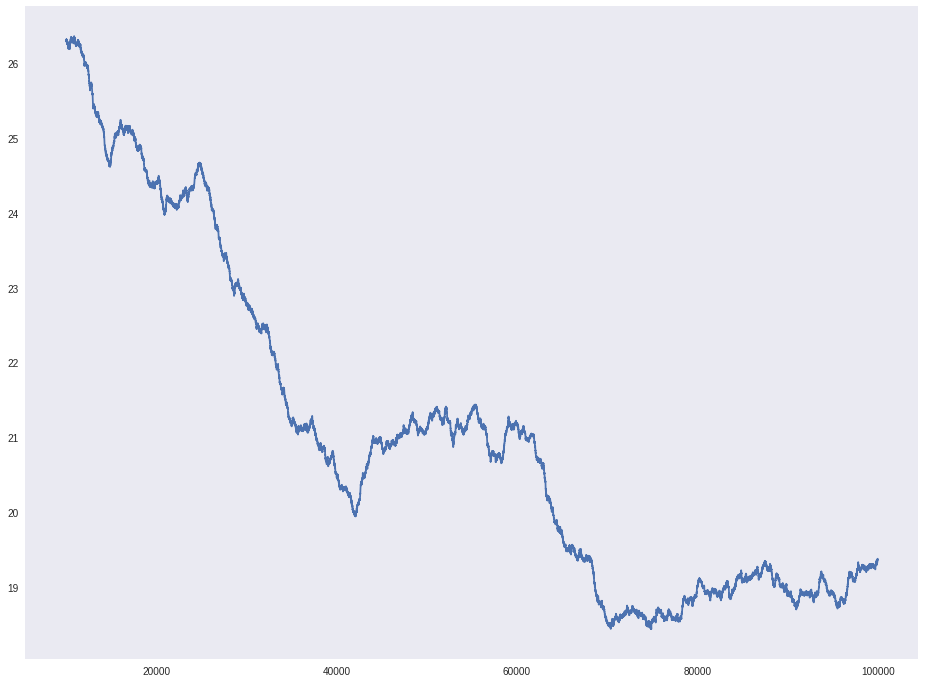

In [21]:
model = LogRegressor3()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

Ответьте на вопрос,  к какому значению ближе всего полученное значение точности:
<font color="red">Варианты ответа:</font>
1. 0.59
2. 0.69
3. 0.79
4. 0.82

## 8. Самые важные слова для тега

Прелесть линейных моделей в том, что они легко интерпретируемы. Вам предлагается вычислить, какие слова вносят наибольший вклад в вероятность каждого из тегов. А затем ответьте на контрольный вопрос.

In [18]:
# Ваш код здесь
for tag1 in model._tags:
    try:
        print(tag1, model._w[tag1][model._vocab[tag1]])
    except KeyError:
        print(tag1, 'wrong key')
#     for tag2 in model._tags:
#         try:
#             print(tag1, tag2, model._w[tag1][model._vocab[tag2]])
#         except KeyError:
#             print(tag1, tag2, 'wrong pair')
# sorted_words_by_weight = sorted(model._w, key=lambda x: x[1])
# l=0
# for key in sorted_words_by_weight:
#     for tag in model._tags:
#         print(key, model._w[tag][key])
#     if l > 10: break
#     l=l+1

python 66.8351382359
android 54.8721792068
html 28.7487186373
c++ 49.6790722711
jquery 98.291277559
java 28.2345956517
ios 45.5656054275
php 76.4269378003
javascript 61.2142248153
c# wrong key


Для многих тегов наличие самого тега в предложении является важным сигналом, у многих сам тег является самым сильным сигналом, что неудивительно. Для каких из тегов само название тега не входит в топ-5 самых важных?

<font color="red">Варианты ответа:</font>
1. java, c#
2. php, javascript
3. html, jquery
4. ios, android

## 9. Сокращаем размер словаря
Сейчас количество слов в словаре около 90 000, если бы это была выборка из 10 миллионов вопросов с сайта StackOverflow, то размер словаря был бы миллионов 10. Регуляризировать модель можно не только изящно математически, но и топорно, например, ограничить размер словаря. Вам предоставляется возможность внести следующие изменения в класс `LogRegressor`:
- добавить в метод `iterate_file` еще один аргумент со значением по умолчанию `update_vocab=True`
- при `update_vocab=True` разрешать добавлять слова в словарь в режиме обучения
- при `update_vocab=False` игнорировать слова не из словаря
- добавить в класс метод `filter_vocab(n=10000)`, который оставит в словаре только топ-n самых популярных слов

In [6]:
from collections import Counter 

class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     lmbda=0.0002, #L2-regularization
                     gamma=0.1, #L1-regularization
                     update_vocab=True,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        acc = 0
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=0.1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0
                pred_tags = set()
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
#                     print(tag, y, sentence)
#                     time.sleep(5)
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab and update_vocab:
                            self._vocab[word] = len(self._vocab)
                        # z += ...
                        if word in self._vocab:
                            z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sigma = ...
                    if z < -10:
                        sigma = 0
                    elif z > 10:
                        sigma = 1
                    else:
                        sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sample_loss += ...
                    if y:
                        if sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(sigma)
                    else:
                        if 1 - sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(1 - sigma)
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        # dLdw = ...
                        dLdw = y - sigma
                        self._b[tag] -= -learning_rate*dLdw
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence: 
                            if word in self._vocab:
                                dLdw = y - sigma - lmbda*(2*gamma*self._w[tag][self._vocab[word]] + (1-gamma)*np.sign(self._w[tag][self._vocab[word]]))
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        
                    if n >= top_n_train:
                        if sigma > 0.9:
                            pred_tags.add(tag)
                    
                n += 1
                if (n >= top_n_train):
                    # вычисляем коэфф жаккара
                    jac = len(pred_tags & tags)/len(pred_tags | tags)
                    acc += jac
                
                
                if n%1000 == 0:
                    print(sample_loss)
                    if (n >= top_n_train):
                        print(pred_tags, tags, jac, acc)
                self._loss.append(sample_loss)
            
        return acc/(total-top_n_train)
    
    def filter_vocab(self, fname=DS_FILE_NAME, n=10000):
        with open(fname, 'r') as f:
            words = []
            for line in f:
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                for word in sentence:
                    words.append(word)
            print("The total word count is:", len(words))
            print("Vocab length is:", len(self._vocab))
            #now use collections.Counter
            c = Counter(words)
            self._vocab = {}
            i=0
            for word, count in c.most_common():
                self._vocab[word] = len(self._vocab)
                if i > n: break
                i=i+1
    
    def predict_proba(self, sentence):
        proba = {}
        sentence = sentence.strip().split(' ')
        for tag in self._tags:
            z = self._b[tag]
            for word in sentence:
                if word in self._vocab:
                    z += self._w[tag][self._vocab[word]]
            if z < -10:
                sigma = 0
            elif z > 10:
                sigma = 1
            else:
                sigma = 1.0/(1.0 + np.exp(-1.0*z))
            proba[tag] = sigma
        return proba

In [22]:
model = LogRegressor()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

36.9612548337
36.8466911204
36.8413614879
3.61739576468
0.00139689194376
0.0
36.8413614879
42.1934421787
5.39017922363
0.0
0.062237578686
0.0
8.86879989211
110.524084464
36.8413614879
73.6827229758


KeyboardInterrupt: 

In [19]:
# оставим только топ 10 000 слов
model.filter_vocab(n=10000)

AttributeError: 'LogRegressor' object has no attribute 'filter_vocab'

In [ ]:
# сделаем еще одну итерацию по датасету, уменьшив скорость обучения в 10 раз
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

Ответьте на вопрос,  к какому значению ближе всего полученное значение точности:
<font color="red">Варианты ответа:</font>
1. 0.48
2. 0.58
3. 0.68
4. 0.78

## 10. Прогнозирование тегов для новых вопросов

В завершение сегодняшней домашки, вам предлагается реализовать метод `predict_proba`, который принимает строку,  содержащую вопрос, а возвращает список предсказанных тегов вопроса с их вероятностями.

In [ ]:
# Обновите определение класса LogRegressor
# Ваш код здесь

36.9612548337
36.8466911204
36.8413614879
3.61739576468
0.00139689194376
0.0
36.8413614879
42.1934421787
5.39017922363
0.0
0.062237578686
0.0
8.86879989211
110.524084464
36.8413614879
73.6827229758
0.0
36.8413614879
36.8413614879
0.000325515157527
0.000416863923721
0.078170623524
73.6827229758
36.8418582023
0.0
0.0
0.0
0.0
0.0
74.9920599898
36.8413614879
9.68844806968e-05
0.0
0.00125911001036
0.0
0.0
73.6827229758
36.8413614879
36.8575992906
0.0
0.0
0.0
73.6827229758
37.3653755545
36.8413614879
0.1362474018
0.0
1.68619458607
0.0
7.80332679911
0.0
38.2309324543
75.7743732264
36.8417967827
0.00753704896197
36.8413614879
0.0
110.524084464
2.57166564299
0.0
0.0
3.30680607125
41.5795469908
0.0
0.452748734584
0.334994310592
0.0
9.00514741519
73.6827229758
44.8525471578
0.0
0.0261814491725
73.6827229758
73.6827229758
0.0
36.8413614879
36.8414274391
5.32058967768
36.8413614879
0.040623566528
0.0
0.0
36.8413614879
0.0
0.0
0.0
73.6827229758
110.524084464
36.8474603759
73.6827229758
3.45093570574

44.8757376523
36.8413614879
36.8423707548
81.4363893656
0.0
0.0
0.00336084284914
73.695105448
81.0356646219
0.0
38.1920307699
0.140063581853
76.6921353132
43.4673308808
38.5531684586
73.6827229758
36.8416163429
36.8413614879
73.6827229758
36.8414297853
36.8413614879
1.94215557464
44.445096949
2.65952477447
36.8413614879
36.8601854103
3.22898469209
0.0
36.8490348472
36.8413614879
0.00734292292104
36.8427944961
0.0
0.0
0.0
36.8413614879
73.6858814543
36.8421380101
53.6998929143
0.0
36.8526795627
0.0
36.8413614879
36.8413614879
36.8689932615
4.93366805089
36.8413614879
0.0
0.0
37.5071067744
0.0
3.22905842025
36.8413614879
0.276753233384
78.1694193419
0.0152049190114
0.0
43.7594690836
36.8416319519
36.841706226
36.8413614879
42.4278540329
16.5684886003
0.0
73.6997980441
37.7167258157
0.0
8.10025124913
36.8413614879
39.2475184467
36.8678256335
0.0
73.6827229758
43.292358254
0.0
0.00217832699853
0.00445608113167
0.0828738809601
4.89791821927
78.2690800041
5.26594374016e-05
0.0327681362557
73

NameError: name 'tags' is not defined

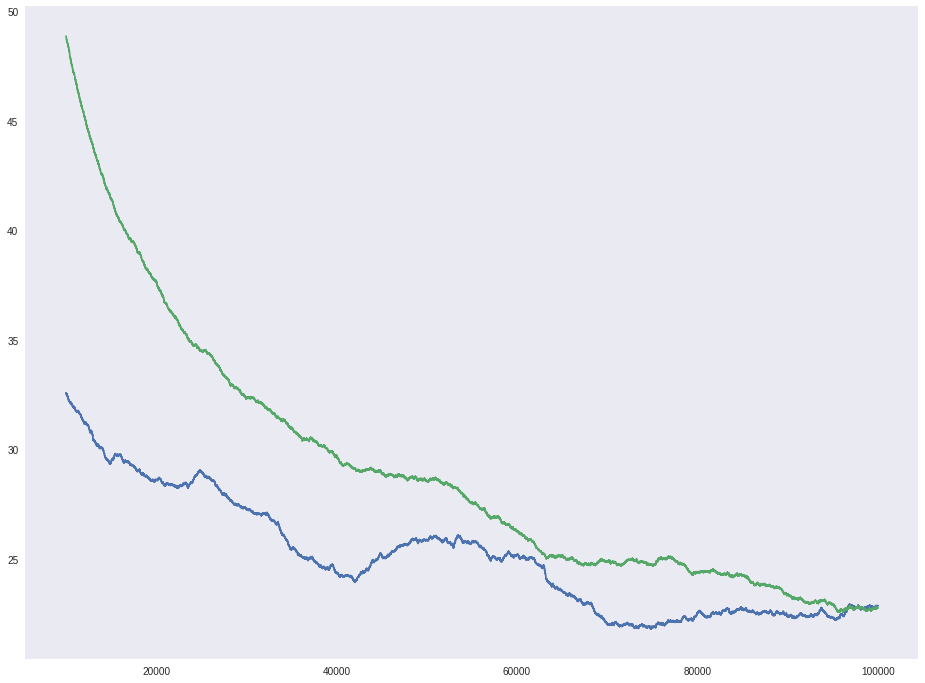

In [7]:
model = LogRegressor()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());
model.filter_vocab(n=10000)
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty level")
tags = model.predict_proba(sentence)
print(tags)

In [8]:
def predict_proba(sentence, model):
    proba = {}
    sentence = sentence.strip().split(' ')
    for tag in model._tags:
        z = model._b[tag]
        for word in sentence:
            if word in model._vocab:
                z += model._w[tag][model._vocab[word]]
        if z < -10:
            sigma = 0
        elif z > 10:
            sigma = 1
        else:
            sigma = 1.0/(1.0 + np.exp(-1.0*z))
        proba[tag] = sigma
    return proba

predict_proba(sentence, model)

{'android': 0,
 'c#': 0,
 'c++': 0,
 'html': 0,
 'ios': 0.0015639361987248614,
 'java': 0,
 'javascript': 0,
 'jquery': 0,
 'php': 0,
 'python': 0.89819648557402176}

In [9]:
model._vocab

{'gt': 0,
 'the': 1,
 'lt': 2,
 'i': 3,
 'to': 4,
 'a': 5,
 'is': 6,
 'in': 7,
 'and': 8,
 'this': 9,
 '0': 10,
 'it': 11,
 'of': 12,
 'if': 13,
 '1': 14,
 'for': 15,
 'that': 16,
 '': 17,
 'class': 18,
 'my': 19,
 'android': 20,
 'have': 21,
 'new': 22,
 'but': 23,
 'on': 24,
 'with': 25,
 'string': 26,
 'id': 27,
 'java': 28,
 'public': 29,
 '+': 30,
 'at': 31,
 'not': 32,
 'name': 33,
 'div': 34,
 'can': 35,
 'function': 36,
 'code': 37,
 '2': 38,
 'from': 39,
 't': 40,
 'data': 41,
 'as': 42,
 'be': 43,
 'get': 44,
 's': 45,
 'am': 46,
 'return': 47,
 'int': 48,
 'using': 49,
 'an': 50,
 'm': 51,
 'when': 52,
 'value': 53,
 'file': 54,
 'text': 55,
 'so': 56,
 'how': 57,
 'amp': 58,
 'var': 59,
 'com': 60,
 'do': 61,
 'type': 62,
 'like': 63,
 'error': 64,
 'or': 65,
 'void': 66,
 'e': 67,
 '3': 68,
 'want': 69,
 'php': 70,
 'what': 71,
 'any': 72,
 'here': 73,
 'there': 74,
 'are': 75,
 'true': 76,
 'which': 77,
 'http': 78,
 'use': 79,
 'all': 80,
 'view': 81,
 'system': 82,
 'ap

In [5]:
model.filter_vocab(n=10000)

NameError: name 'fname' is not defined

In [ ]:
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [20]:
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty level")
tags = model.predict_proba(sentence)
print(tags)

Ответьте на вопрос, какой или какие теги ассоциируются с данным вопросом, если порог принятия равен $0.9$?:
<font color="red">Варианты ответа:</font>
1. android
2. ios
3. ios, php
4. c#, c++, ods